In [2]:
import pandas as pd
from pandarallel import pandarallel

pandarallel.initialize()
from glob import glob
import os, json
import numpy as np
import re
import matplotlib.pyplot as plt
import unicodedata
from tqdm.notebook import tqdm

tqdm.pandas()

from data.preprocessing import preprocess_genius_text

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


# Analyse - focus sur un artiste

In [6]:
x = ("je",)
x[1:]

()

 ## load

In [3]:
from data.load import load_df_dataset

In [63]:
df_rohff = load_df_dataset("data/datasets/genius-1908-rohff/")
print(df_rohff.shape)
df_rohff["lyrics"]

Loading ['data/datasets/genius-1908-rohff\\df_genius_rohff_all_songs_202212.csv']
(340, 129)


0      Dans ta race Lyrics[Couplet 1 : Rohff]\nJ'me p...
1      Appelle-moi Rohff Lyrics[Intro]\nRohff au micr...
2      Apprends à vivre Lyrics[Intro]\nJ't'apprends r...
3      Catastrohff Lyrics[Couplet 1]\nDémarrage hold-...
4      Du fond du cœur Lyrics[Intro]\nAu clair de la ...
                             ...                        
335    Kunta Sankara Lyrics[Refrain]\nKunta SankaraYo...
336    Le pouvoir 2 LyricsRefrain\n\nT’arrives comme ...
337            Numéro 1 LyricsAhYou might also likeEmbed
338    T ki LyricsA mort les juifs\nEt les arabes\nEt...
339    Zlatana (West Indies Remix) Lyrics[Intro]\nDeb...
Name: lyrics, Length: 340, dtype: object

In [74]:
df_rohff.columns.tolist()

['annotation_count',
 'api_path',
 'artist_names',
 'full_title',
 'header_image_thumbnail_url',
 'header_image_url',
 'id',
 'language',
 'lyrics_owner_id',
 'lyrics_state',
 'path',
 'pyongs_count',
 'relationships_index_url',
 'release_date_for_display',
 'release_date_with_abbreviated_month_for_display',
 'song_art_image_thumbnail_url',
 'song_art_image_url',
 'title',
 'title_with_featured',
 'url',
 'featured_artists',
 'apple_music_id',
 'apple_music_player_url',
 'embed_content',
 'featured_video',
 'lyrics_placeholder_reason',
 'recording_location',
 'release_date',
 'custom_performances',
 'lyrics_marked_complete_by',
 'lyrics_marked_staff_approved_by',
 'media',
 'producer_artists',
 'song_relationships',
 'translation_songs',
 'verified_annotations_by',
 'verified_contributors',
 'verified_lyrics_by',
 'writer_artists',
 'artist',
 'lyrics',
 'release_date_components.year',
 'release_date_components.month',
 'release_date_components.day',
 'stats.accepted_annotations',
 'st

## 2. Date

In [90]:
for album_name, year in [("La Cuenta", 2010), ("10 ans d’avance", 2004), ("Talents Fâchés 2", 2004), ("Talents Fâchés 4", 2009)]:
    df_rohff.loc[df_rohff["album.name"] == album_name, "release_date_components.year"] = year

df_rohff[df_rohff["release_date_components.year"].isnull()][
    ["title", "artist_names", "album.name", "release_date_components.year"]]

,title,artist_names,album.name,release_date_components.year
331,Excuse Moi,Rohff,Le cauchemar du rap français - Chapitre 1,NaN
334,Dis mon nom (avec jasmin lopez),Rohff,NaN,NaN
335,Kunta Sankara,Rohff,NaN,NaN
336,Le pouvoir 2,Rohff,NaN,NaN
337,Numéro 1,Rohff,NaN,NaN
338,T ki,Rohff,NaN,NaN
339,Zlatana (West Indies Remix),Rohff,NaN,NaN


In [119]:
df_rohff["release_date_components.year"] = df_rohff["release_date_components.year"].fillna(-1)
df_rohff["release_date_components.year"] = df_rohff["release_date_components.year"].astype(int)
df_rohff["release_date_components.year"] = df_rohff["release_date_components.year"].replace(-1,np.nan)

In [121]:
df_rohff["release_date_components.year"].info()

<class 'pandas.core.series.Series'>
Int64Index: 340 entries, 0 to 339
Series name: release_date_components.year
Non-Null Count  Dtype  
--------------  -----  
333 non-null    float64
dtypes: float64(1)
memory usage: 13.4 KB


<AxesSubplot: >

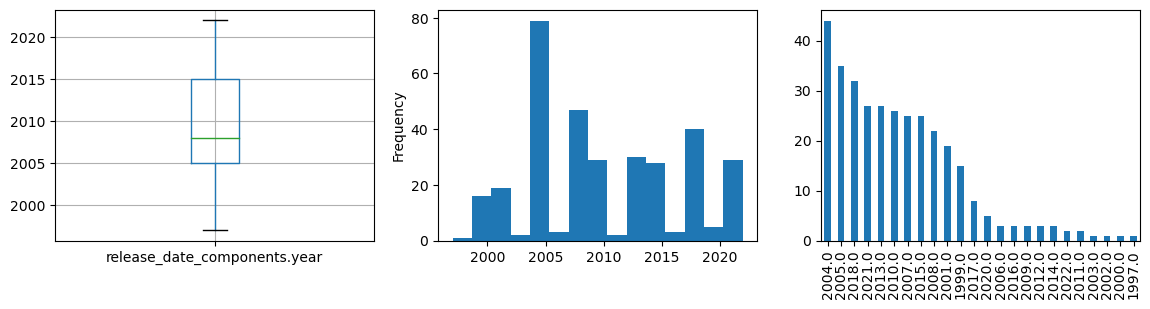

In [120]:
def plot_year_graphs(df):
    plt.figure(figsize=(14,3))

    plt.subplot(1,3,1)
    df.boxplot(column=["release_date_components.year"])

    plt.subplot(1,3,2)
    df["release_date_components.year"].plot.hist(bins=15)

    plt.subplot(1,3,3)
    df["release_date_components.year"].value_counts().plot.bar()


plot_year_graphs(df_rohff)

## 3. Lyrics
### preprocessing

In [64]:
from data.preprocessing import preprocess_genius_text
from functools import partial

In [14]:
text = df_rohff["lyrics"][0]
text = preprocess_genius_text(text, lemmatization=True, token_output=True)
print(text)
text

['je', 'me', 'poste', 'sur', 'le', 'beat', ',', 'je', 'attend', 'que', 'tu', "t'", 'ramollisse', ',', 'mc', 'je', 'venir', 'dégainer', '\n', 'mon', 'mission', 'être', 'tellement', 'réussir', 'que', 'on', 'dire', 'que', 'tu', 'te', 'es', 'suicider', '\n', 'aussi', 'précis', 'que', 'le', 'enfoiré', "qu'", 'avoir', 'buter', 'kennedy', '\n', 'je', 'défouraille', 'comme', 'ali', ',', 'ce', 'être', 'hardcore', 'pour', "n'", 'importe', 'quel', 'mc', '\n', 'dans', 'le', 'guet', '-', 'apen', ',', 'on', 'te', 'saigne', 'au', 'mic', 'comme', 'dans', 'le', 'vie', 'quotidienne', '\n', 'je', 'ajoute', 'même', 'pour', 'le', 'gens', 'qui', 'se', 'plaindre', 'que', 'il', 'avoir', 'le', 'haine', 'ou', 'que', 'il', 'nous', 'craindre', '\n', 'falloir', 'pas', 'tmennek', ',', 'khouyer', "y'", 'avoir', 'pas', 'de', 'détail', "y'", 'avoir', 'rien', "qu'", 'un', 'représaille', '\n', 'je', 'voir', 'le', 'caille', ',', 'ce', 'être', 'pour', 'le', 'fun', 'ou', 'pour', 'le', 'maille', '\n', 'je', 'reste', 'origin

['je',
 'me',
 'poste',
 'sur',
 'le',
 'beat',
 ',',
 'je',
 'attend',
 'que',
 'tu',
 "t'",
 'ramollisse',
 ',',
 'mc',
 'je',
 'venir',
 'dégainer',
 '\n',
 'mon',
 'mission',
 'être',
 'tellement',
 'réussir',
 'que',
 'on',
 'dire',
 'que',
 'tu',
 'te',
 'es',
 'suicider',
 '\n',
 'aussi',
 'précis',
 'que',
 'le',
 'enfoiré',
 "qu'",
 'avoir',
 'buter',
 'kennedy',
 '\n',
 'je',
 'défouraille',
 'comme',
 'ali',
 ',',
 'ce',
 'être',
 'hardcore',
 'pour',
 "n'",
 'importe',
 'quel',
 'mc',
 '\n',
 'dans',
 'le',
 'guet',
 '-',
 'apen',
 ',',
 'on',
 'te',
 'saigne',
 'au',
 'mic',
 'comme',
 'dans',
 'le',
 'vie',
 'quotidienne',
 '\n',
 'je',
 'ajoute',
 'même',
 'pour',
 'le',
 'gens',
 'qui',
 'se',
 'plaindre',
 'que',
 'il',
 'avoir',
 'le',
 'haine',
 'ou',
 'que',
 'il',
 'nous',
 'craindre',
 '\n',
 'falloir',
 'pas',
 'tmennek',
 ',',
 'khouyer',
 "y'",
 'avoir',
 'pas',
 'de',
 'détail',
 "y'",
 'avoir',
 'rien',
 "qu'",
 'un',
 'représaille',
 '\n',
 'je',
 'voir',
 '

In [66]:
def preprocess_genius_lyrics_from_df(df):
    df = df.copy()
    preprocessing = partial(preprocess_genius_text, lemmatization=True, stop_words_removal=True,
                            punct_removal=True, token_output=True,
                            stop_words_to_keep=["je", "tu", "il", "elle", "nous", "vous", "être", "avoir"])
    df["lyrics_tokens"] = df['lyrics'].parallel_apply(preprocessing)  # todo : rename _tokens
    return df


df_rohff = preprocess_genius_lyrics_from_df(df_rohff)
df_rohff

,annotation_count,api_path,artist_names,full_title,header_image_thumbnail_url,header_image_url,id,language,lyrics_owner_id,lyrics_state,...,lyrics_marked_complete_by.login,lyrics_marked_complete_by.name,lyrics_marked_complete_by.role_for_display,lyrics_marked_complete_by.url,lyrics_marked_complete_by.current_user_metadata.permissions,lyrics_marked_complete_by.current_user_metadata.excluded_permissions,lyrics_marked_complete_by.current_user_metadata.interactions.following,release_date_components,album,lyrics_tokens
0,5,/songs/2273542,"Rohff (Ft. 113, Kery James, Sayd des Mureaux &...","Dans ta race by Rohff (Ft. 113, Kery James, Sa...",https://images.genius.com/491e36f4a9aa9808d0d4...,https://images.genius.com/491e36f4a9aa9808d0d4...,2273542,fr,1343730,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[poste, beat, attend, tu, ramollisse, mc, veni..."
1,5,/songs/61732,Rohff,Appelle-moi Rohff by Rohff,https://images.genius.com/2212fdcfad427cbcc357...,https://images.genius.com/2212fdcfad427cbcc357...,61732,fr,55217,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[rohff, micro, \n, microphone, contact, attaqu..."
2,2,/songs/182778,Rohff (Ft. Leïla Rami),Apprends à vivre by Rohff (Ft. Leïla Rami),https://images.genius.com/2212fdcfad427cbcc357...,https://images.genius.com/2212fdcfad427cbcc357...,182778,fr,67668,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[apprend, rien, gros, sommeil, cousin, mort, \..."
3,3,/songs/99876,Rohff,Catastrohff by Rohff,https://images.genius.com/2212fdcfad427cbcc357...,https://images.genius.com/2212fdcfad427cbcc357...,99876,fr,133353,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[démarrage, hold, up, meilleur, pilote, david,..."
4,9,/songs/137294,Rohff,Du fond du cœur by Rohff,https://images.genius.com/2212fdcfad427cbcc357...,https://images.genius.com/2212fdcfad427cbcc357...,137294,fr,133353,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[clair, lune, chandelle, mourir, \n, pleurer, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,1,/songs/5478298,Rohff,Kunta Sankara by Rohff,https://images.genius.com/b5ba714ed6fa419ebb72...,https://images.genius.com/b5ba714ed6fa419ebb72...,5478298,en,196265,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[kunter, sankarayou, might, also, likeembed]"
336,12,/songs/95639,Rohff,Le pouvoir 2 by Rohff,https://images.genius.com/b5ba714ed6fa419ebb72...,https://images.genius.com/b5ba714ed6fa419ebb72...,95639,NaN,152734,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[arrive, coup, crasse, coup, crosse, néger, \n..."
337,1,/songs/100238,Rohff,Numéro 1 by Rohff,https://images.genius.com/b5ba714ed6fa419ebb72...,https://images.genius.com/b5ba714ed6fa419ebb72...,100238,NaN,67668,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
338,0,/songs/3763579,Rohff,T ki by Rohff,https://images.genius.com/b5ba714ed6fa419ebb72...,https://images.genius.com/b5ba714ed6fa419ebb72...,3763579,fr,6504729,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[arabe, \n, noir, \n, mme, evezard, c, gros, p..."


,annotation_count,api_path,artist_names,full_title,header_image_thumbnail_url,header_image_url,id,language,lyrics_owner_id,lyrics_state,...,lyrics_marked_complete_by.login,lyrics_marked_complete_by.name,lyrics_marked_complete_by.role_for_display,lyrics_marked_complete_by.url,lyrics_marked_complete_by.current_user_metadata.permissions,lyrics_marked_complete_by.current_user_metadata.excluded_permissions,lyrics_marked_complete_by.current_user_metadata.interactions.following,release_date_components,album,lyrics_tokens
0,5,/songs/2273542,"Rohff (Ft. 113, Kery James, Sayd des Mureaux &...","Dans ta race by Rohff (Ft. 113, Kery James, Sa...",https://images.genius.com/491e36f4a9aa9808d0d4...,https://images.genius.com/491e36f4a9aa9808d0d4...,2273542,fr,1343730,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[poste, beat, attend, tu, ramollisse, mc, veni..."
1,5,/songs/61732,Rohff,Appelle-moi Rohff by Rohff,https://images.genius.com/2212fdcfad427cbcc357...,https://images.genius.com/2212fdcfad427cbcc357...,61732,fr,55217,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[rohff, micro, \n, microphone, contact, attaqu..."
2,2,/songs/182778,Rohff (Ft. Leïla Rami),Apprends à vivre by Rohff (Ft. Leïla Rami),https://images.genius.com/2212fdcfad427cbcc357...,https://images.genius.com/2212fdcfad427cbcc357...,182778,fr,67668,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[apprend, rien, gros, sommeil, cousin, mort, \..."
3,3,/songs/99876,Rohff,Catastrohff by Rohff,https://images.genius.com/2212fdcfad427cbcc357...,https://images.genius.com/2212fdcfad427cbcc357...,99876,fr,133353,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[démarrage, hold, up, meilleur, pilote, david,..."
4,9,/songs/137294,Rohff,Du fond du cœur by Rohff,https://images.genius.com/2212fdcfad427cbcc357...,https://images.genius.com/2212fdcfad427cbcc357...,137294,fr,133353,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[clair, lune, chandelle, mourir, \n, pleurer, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,1,/songs/5478298,Rohff,Kunta Sankara by Rohff,https://images.genius.com/b5ba714ed6fa419ebb72...,https://images.genius.com/b5ba714ed6fa419ebb72...,5478298,en,196265,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[kunter, sankarayou, might, also, likeembed]"
336,12,/songs/95639,Rohff,Le pouvoir 2 by Rohff,https://images.genius.com/b5ba714ed6fa419ebb72...,https://images.genius.com/b5ba714ed6fa419ebb72...,95639,NaN,152734,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[arrive, coup, crasse, coup, crosse, néger, \n..."
337,1,/songs/100238,Rohff,Numéro 1 by Rohff,https://images.genius.com/b5ba714ed6fa419ebb72...,https://images.genius.com/b5ba714ed6fa419ebb72...,100238,NaN,67668,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
338,0,/songs/3763579,Rohff,T ki by Rohff,https://images.genius.com/b5ba714ed6fa419ebb72...,https://images.genius.com/b5ba714ed6fa419ebb72...,3763579,fr,6504729,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[arabe, \n, noir, \n, mme, evezard, c, gros, p..."


### • Vocabulaire

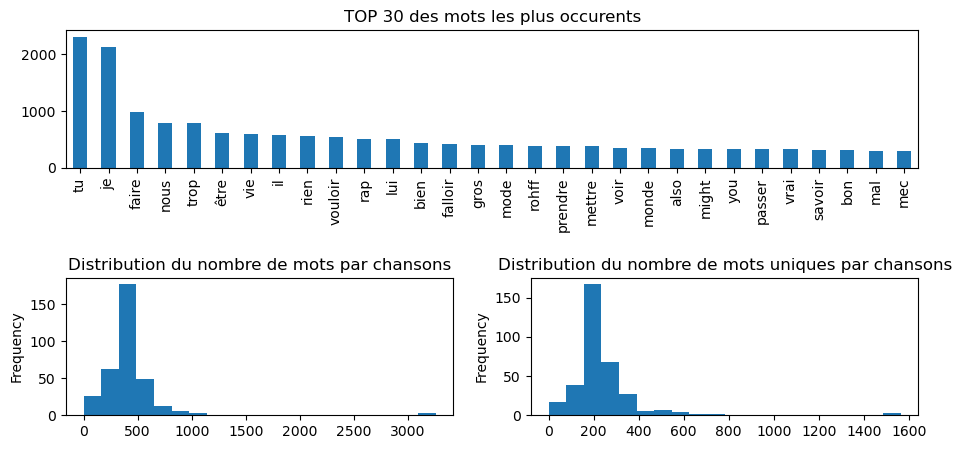

\n         26219
tu          2311
je          2128
faire        983
nous         792
           ...  
tantis         1
minch          1
parigo         1
yougo          1
dévorer        1
Name: lyrics_tokens, Length: 17039, dtype: int64

In [67]:
def plot_vocabulary_analyze(df: pd.DataFrame, top_words: int = 30, tokens_to_drop=["\n", "y'"]) -> None:
    df["lyrics_tokens_len"] = df['lyrics_tokens'].apply(lambda x: len(x))
    df["lyrics_unique_tokens_len"] = df['lyrics_tokens'].apply(lambda x: len(set(x)))
    plt.figure(figsize=(11, 5))
    grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.8)

    ax = plt.subplot(grid[0, :])
    ax.set_title(f"TOP {top_words} des mots les plus occurents")
    tokens_exploded = df["lyrics_tokens"].explode()
    tokens_exploded.value_counts().drop(index=tokens_to_drop)[:top_words].plot.bar()

    ax = plt.subplot(grid[1, 0])
    ax.set_title("Distribution du nombre de mots par chansons")
    df["lyrics_tokens_len"].plot.hist(bins=20)

    ax = plt.subplot(grid[1, 1])
    ax.set_title("Distribution du nombre de mots uniques par chansons")
    df["lyrics_unique_tokens_len"].plot.hist(bins=20)

    #plt.legend()
    plt.show()
    return tokens_exploded.value_counts()


plot_vocabulary_analyze(df_rohff)

# Analyze - focus sur l'ensemble des datasets

## load

In [68]:
from data.load import load_df_all_datasets

In [69]:
df_datasets = load_df_all_datasets("data/datasets/")
print(df_datasets.shape)
df_datasets

(23018, 156)


,annotation_count,api_path,artist_names,full_title,header_image_thumbnail_url,header_image_url,id,language,lyrics_owner_id,lyrics_state,...,lyrics_marked_staff_approved_by.id,lyrics_marked_staff_approved_by.iq,lyrics_marked_staff_approved_by.login,lyrics_marked_staff_approved_by.name,lyrics_marked_staff_approved_by.role_for_display,lyrics_marked_staff_approved_by.url,lyrics_marked_staff_approved_by.current_user_metadata.permissions,lyrics_marked_staff_approved_by.current_user_metadata.excluded_permissions,lyrics_marked_staff_approved_by.current_user_metadata.interactions.following,stats.concurrents
0,16,/songs/2983270,Kobo,Memo Freestyle by Kobo,https://images.genius.com/5f2cfea4b14d2202c825...,https://images.genius.com/5f2cfea4b14d2202c825...,2983270,en,4272949,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,/songs/3028067,Kobo,Présumé sobre by Kobo,https://images.genius.com/a4e4768e78b579034772...,https://images.genius.com/a4e4768e78b579034772...,3028067,fr,4410941,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,/songs/2872317,Kobo,What's my name? by Kobo,https://images.genius.com/a4dcf3f37c2814f6217c...,https://images.genius.com/a4dcf3f37c2814f6217c...,2872317,fr,3797458,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,/songs/3296523,Kobo,Au pays des droits de l'Homme by Kobo,https://images.genius.com/ecdf2d2857110006ec1d...,https://images.genius.com/ecdf2d2857110006ec1d...,3296523,fr,5428057,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,/songs/3174234,Kobo (Ft. Zdero),Łapię za majka by Kobo (Ft. Zdero),https://images.genius.com/af68bcc1c27c60c8670c...,https://images.genius.com/af68bcc1c27c60c8670c...,3174234,pl,4982117,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23048,0,/songs/7645050,YL,Sans direction by YL,https://images.genius.com/d6f6e86906318277c4e6...,https://images.genius.com/d6f6e86906318277c4e6...,7645050,fr,4838104,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23049,0,/songs/7645038,YL,Tata Fatima by YL,https://images.genius.com/f04773b22d769a2ea9fb...,https://images.genius.com/f04773b22d769a2ea9fb...,7645038,fr,4838104,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23050,0,/songs/7645037,YL,Y by YL,https://images.genius.com/d6f6e86906318277c4e6...,https://images.genius.com/d6f6e86906318277c4e6...,7645037,fr,4838104,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23051,0,/songs/7724444,YL,Booska Piccolo by YL,https://images.genius.com/af07e96800b285ea3611...,https://images.genius.com/af07e96800b285ea3611...,7724444,fr,4838104,complete,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
n_unique_artists = len(df_datasets["artist"].unique())
print(f"{n_unique_artists} unique artists")

199 unique artists


<AxesSubplot: title={'center': 'Nombre de lyrics'}>

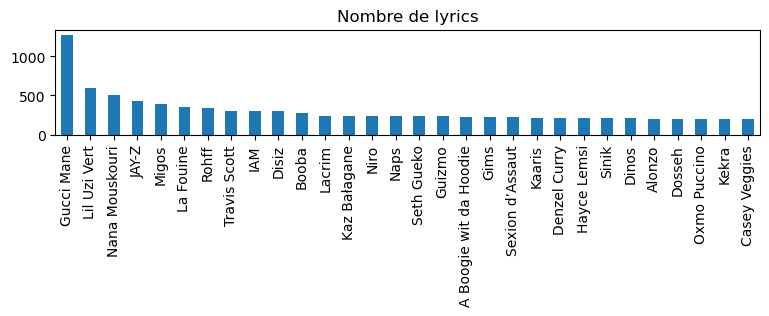

In [133]:
cb = 30
plt.figure(figsize=(20, 3))
ax = plt.subplot(2, 2, 1)
ax.set_title("Nombre de lyrics")
df_datasets.artist.value_counts()[:cb].plot.bar()

nom des titres les plus recurrentres

nombre de phrases les plus recurrent (phrase, decomposer en 5-6-7-8 grams)

## 2. Date

In [ ]:
plot_year_graphs(df_datasets)

## 3. Lyrics
### preprocessing

In [134]:
df_datasets = preprocess_genius_lyrics_from_df(df_datasets)
df_datasets.shape

H:\anaconda3\envs\nlp_rap_env\lib\site-packages\pandarallel\data_types\series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


(23018, 157)

### • Vocabulaire

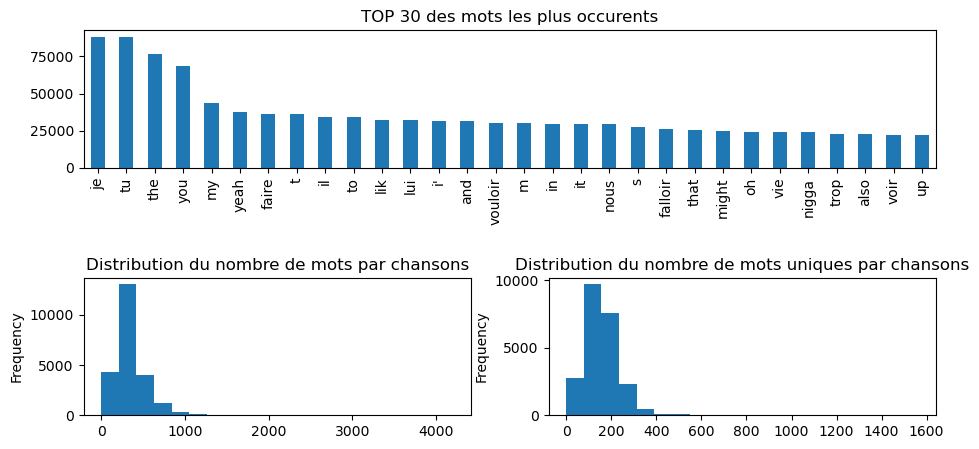

\n          1254756
je            88250
tu            88135
the           76702
you           68438
             ...   
перки             1
палим             1
крузак            1
ебашим            1
timonier          1
Name: lyrics_tokens, Length: 170063, dtype: int64

In [135]:
plot_vocabulary_analyze(df_datasets)

## verification des langues